In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

FILES = {
    "Apple":  "Apple_clean.csv",
    "Samsung":"Samsung_clean.csv",
    "Xiaomi": "Xiaomi_clean.csv"
}

FORECAST_START = pd.to_datetime("2025-10-29")
FORECAST_DAYS = 30
TIME_STEP = 40     


In [2]:
def load_series(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values("Date").reset_index(drop=True)
    return df[['Date','Close']]



In [3]:
def build_lstm(ts):
    model = Sequential([
        Input(shape=(ts, 1)),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_gru(ts):
    model = Sequential([
        Input(shape=(ts, 1)),
        GRU(64),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [4]:
def make_windows(arr, ts):
    X, y = [], []
    for i in range(len(arr) - ts):
        X.append(arr[i:i+ts, 0])
        y.append(arr[i+ts, 0])
    return np.array(X).reshape((-1, ts, 1)), np.array(y)

In [5]:
def forecast_next(model, last_win, n, scaler):
    seq = list(last_win.flatten())
    preds = []

    for _ in range(n):
        x = np.array(seq[-len(last_win):]).reshape(1, len(last_win), 1)
        y = model.predict(x, verbose=0)[0][0]
        seq.append(y)
        preds.append(y)

    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()


In [6]:
results = {}

for name, path in FILES.items():

    print(f"\n=== Processing {name} ===")

    df = load_series(path)
    close = df["Close"].values.reshape(-1, 1)

    n = len(close)
    ts = min(TIME_STEP, n // 3) if n < TIME_STEP + 10 else TIME_STEP

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close)

    # Make windows
    X_all, y_all = make_windows(scaled, ts)
    total = len(X_all)

    train_end = int(0.6 * total)
    val_end   = int(0.8 * total)

    X_train, y_train = X_all[:train_end], y_all[:train_end]
    X_val,   y_val   = X_all[train_end:val_end], y_all[train_end:val_end]
    X_test,  y_test  = X_all[val_end:], y_all[val_end:]

    print(f"Windows → Train {len(X_train)}, Val {len(X_val)}, Test {len(X_test)}")

    # Train LSTM
    lstm = build_lstm(ts)
    lstm.fit(X_train, y_train, epochs=80, batch_size=16,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
             verbose=0)

    # Train GRU
    gru = build_gru(ts)
    gru.fit(X_train, y_train, epochs=80, batch_size=16,
            validation_data=(X_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
            verbose=0)

    # Forecast
    last_window = scaled[-ts:]
    lstm_fc = forecast_next(lstm, last_window, FORECAST_DAYS, scaler)
    gru_fc  = forecast_next(gru,  last_window, FORECAST_DAYS, scaler)

    dates = pd.date_range(start=FORECAST_START, periods=FORECAST_DAYS)

    results[name] = {
        "dates": dates,
        "lstm": lstm_fc,
        "gru": gru_fc
    }




=== Processing Apple ===
Windows → Train 2365, Val 788, Test 789

=== Processing Samsung ===
Windows → Train 2311, Val 770, Test 771

=== Processing Xiaomi ===
Windows → Train 1056, Val 352, Test 352


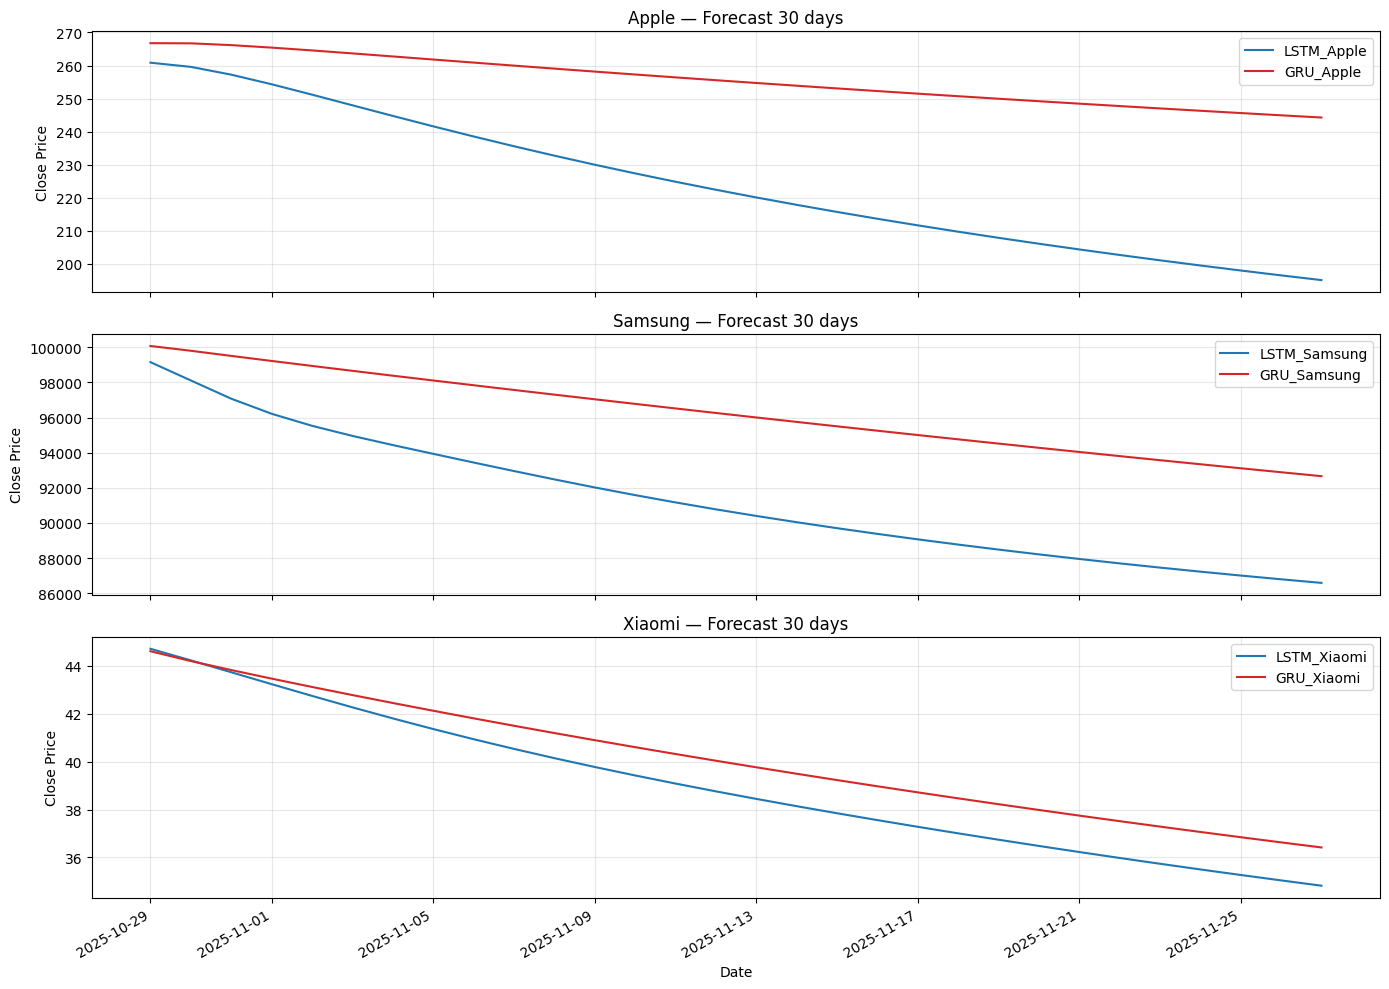

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

stock_list = ["Apple", "Samsung", "Xiaomi"]
colors = {
    "LSTM": "tab:blue",
    "GRU":  "tab:red"
}

for ax, stock in zip(axes, stock_list):
    d = results[stock]["dates"]
    ax.plot(d, results[stock]["lstm"], label=f"LSTM_{stock}", color=colors["LSTM"])
    ax.plot(d, results[stock]["gru"],  label=f"GRU_{stock}",  color=colors["GRU"])

    ax.set_title(f"{stock} — Forecast 30 days")
    ax.set_ylabel("Close Price")
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [8]:
# -------------------------
# PRINT 30-DAY FORECAST TABLES
# -------------------------

for stock in stock_list:
    print("\n==============================================")
    print(f"       30-DAY FORECAST TABLE — {stock}")
    print("==============================================")

    df_table = pd.DataFrame({
        "Date": results[stock]["dates"],
        "LSTM_Forecast": results[stock]["lstm"],
        "GRU_Forecast":  results[stock]["gru"]
    })

    # Làm đẹp bảng
    df_table["Date"] = df_table["Date"].dt.strftime("%Y-%m-%d")
    df_table = df_table.round(4)

    print(df_table.to_string(index=False))



       30-DAY FORECAST TABLE — Apple
      Date  LSTM_Forecast  GRU_Forecast
2025-10-29     260.845490    266.753601
2025-10-30     259.589813    266.707886
2025-10-31     257.227814    266.164795
2025-11-01     254.328201    265.413788
2025-11-02     251.187805    264.562988
2025-11-03     247.967194    263.663208
2025-11-04     244.756195    262.741302
2025-11-05     241.605499    261.812714
2025-11-06     238.543304    260.886200
2025-11-07     235.584198    259.967285
2025-11-08     232.734802    259.058990
2025-11-09     229.996201    258.163208
2025-11-10     227.367004    257.280487
2025-11-11     224.843399    256.411804
2025-11-12     222.420807    255.556793
2025-11-13     220.094498    254.715897
2025-11-14     217.859100    253.888596
2025-11-15     215.709702    253.074799
2025-11-16     213.641098    252.274094
2025-11-17     211.648895    251.486404
2025-11-18     209.728394    250.711395
2025-11-19     207.875702    249.948807
2025-11-20     206.086807    249.198196
20